### Import Statements

In [1]:
#importing all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/calebagoha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/calebagoha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/calebagoha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Main Research Question
How have the sound and emotional themes of popular music evolved from 2000 to 2024, and what does this reveal about shifting cultural moods and industry trends?

### Sub Questions
1. How has the emotional tone of popular music changed over time?
2. What lyrical themes dominate different time periods?
3. Is popular music becoming more musically and lyrically homogeneous?


In [2]:
# Load the dataset
df = pd.read_csv('top_songs_with_lyrics.csv')

# Basic text preprocessing
def clean_lyrics(text):
    """ Clean the lyrics text by removing section headers, filler words, and non-alphabetic characters"""
    if pd.isna(text):
        return ""
    # Remove everything before the first section header like [Intro:], [Verse:], etc.
    section_header = re.search(r'\[.*?\]', text)
    if section_header:
        text = text[section_header.start():]
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # remove [verse], [chorus], etc.
    text = re.sub(r'\n', ' ', text)      # remove newlines
    text = re.sub(r'[^a-z\s]', '', text) # keep only letters
    text = re.sub(r'\s+', ' ', text)     # collapse multiple spaces
    
    # Remove common filler/interjection/adlibs words
    filler_words = [
        r"\bim\b", r"\bmm+\b", r"\byeah+\b", r"\byea+\b", r"\bye+\b", r"\boh+\b", r"\booh+\b",
        r"\bla+\b", r"\bna+\b", r"\buh+\b", r"\bah+\b", r"\bwhoa+\b", r"\bhey+\b", r"\bhmm+\b", r"\bwoah+\b",
        r"\bwoo+\b", r"\bohoh+\b"
    ]
    for word in filler_words:
        text = re.sub(word, '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_lyrics'] = df['lyrics'].progress_apply(clean_lyrics)

# Drop rows with empty lyrics
df = df[df['clean_lyrics'].str.strip() != '']

100%|██████████| 2426/2426 [00:01<00:00, 2238.10it/s]


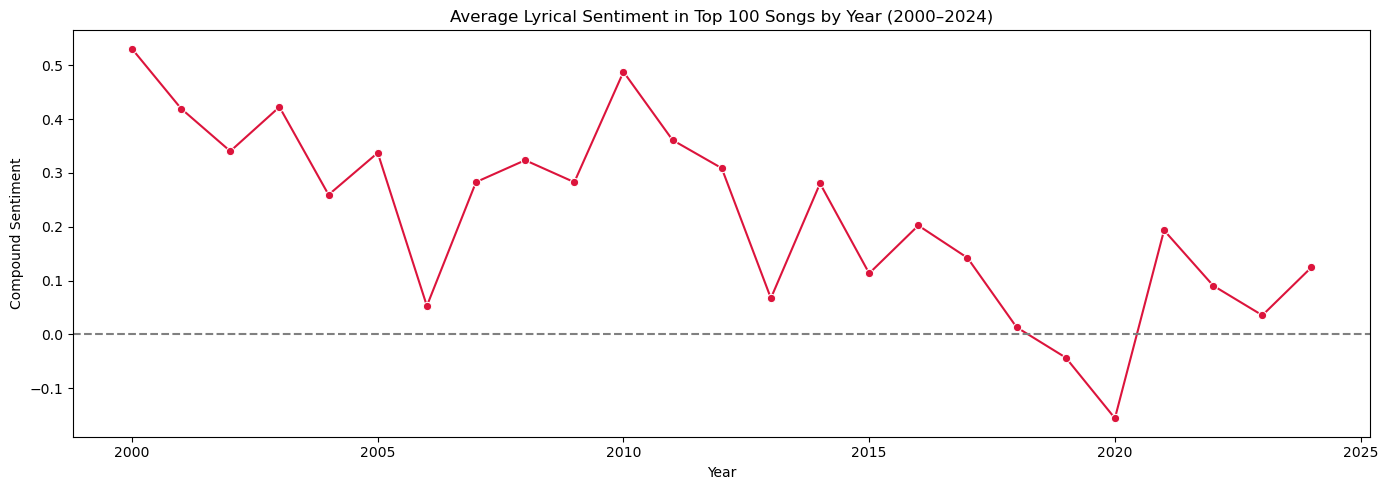

In [3]:
# perform sentiment analysis using VADER

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

df['vader_compound'] = df['clean_lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])

# plotting the average sentiment over the years
yearly_sentiment = df.groupby('year')['vader_compound'].mean()

plt.figure(figsize=(14, 5))
sns.lineplot(data=yearly_sentiment, marker='o', color='crimson')
plt.title('Average Lyrical Sentiment in Top 100 Songs by Year (2000–2024)')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Compound Sentiment')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

To answer the first sub question about the emotional tone of of songs, I used Vader's sentiment analysis package. 

The emotional tone of popular music has undergone significant shifts, with a notable decline in positivity over the past 25 years:
 - Early 2000s (2000-2003): Music maintained relatively high positive sentiment (0.4-0.5), suggesting optimistic, upbeat themes dominated popular culture.
 - Mid-2000s Crisis (2006): A dramatic drop to near-zero sentiment coincides with economic uncertainty and cultural shifts, representing one of the most emotionally neutral periods in popular music.
- 2010s Volatility: The decade shows extreme fluctuations, with a peak around 2010 (0.48) followed by declining positivity through the mid-2010s.
- Recent Decline (2019-2020): Sentiment plummeted to negative territory (-0.15 in 2020), likely reflecting pandemic-era anxiety, social unrest, and economic uncertainty.
- Current Recovery (2021-2024): While showing some recovery, sentiment remains well below early 2000s levels, suggesting a "new normal" of more complex, less purely optimistic popular music.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Create document-term matrix
vectorizer = CountVectorizer(max_df=0.85, min_df=5, ngram_range=(1, 2), stop_words='english', max_features=5000)
dtm = vectorizer.fit_transform(df['clean_lyrics'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=7, random_state=42, max_iter=50, learning_method='batch')
lda.fit(dtm)

# Show top words per topic
def display_topics(model, feature_names, no_top_words=20):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = top_features
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names)
for t, words in topics.items():
    print(f"{t}: {words}")

Topic 0: ['love', 'dont', 'baby', 'know', 'just', 'like', 'wanna', 'cause', 'want', 'let', 'got', 'girl', 'say', 'youre', 'way', 'ill', 'good', 'feel', 'right', 'tell']
Topic 1: ['know', 'youre', 'like', 'just', 'time', 'dont', 'think', 'better', 'need', 'away', 'make', 'ive', 'say', 'said', 'cause', 'life', 'day', 'gonna', 'got', 'ill']
Topic 2: ['bitch', 'fuck', 'like', 'got', 'nigga', 'em', 'aint', 'shit', 'money', 'dont', 'niggas', 'voc', 'eu', 'thats', 'know', 'tell', 'fuckin', 'hot', 'man', 'turn']
Topic 3: ['dance', 'night', 'lets', 'evet', 'bir', 'da', 've', 'bu', 'music', 'ben', 'iin', 'senin', 'seni', 'eh', 'beni', 'ohohohohoh', 'gibi', 'dj', 'rock', 'eh eh']
Topic 4: ['ich', 'shake', 'du', 'die', 'nicht', 'es', 'und', 'oohooh', 'gonna', 'nana', 'mich', 'shake shake', 'break', 'ist', 'high', 'das', 'sie', 'nananana', 'zu', 'bin']
Topic 5: ['que', 'te', 'en', 'mi', 'se', 'lo', 'el', 'yo', 'tu', 'por', 'es', 'si', 'je', 'una', 'como', 'pero', 'ey', 'para', 'ti', 'le']
Topic 6: 

In [5]:
# compute coherense score for the LDA model to evaluate topic quality

texts = [doc.split() for doc in df['clean_lyrics']]
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Convert sklearn LDA to gensim wrapper
from gensim.models.ldamodel import LdaModel
lda_gensim = LdaModel(corpus=corpus, id2word=id2word, num_topics=5)

coherence_model = CoherenceModel(model=lda_gensim, texts=texts, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f" Coherence score: {coherence_score}")

 Coherence score: 0.4500248999982933


In [6]:
# Mapping topic indices to descriptive labels
topic_labels = {
    0: "Romance_Desire_Love",
    1: "Reflection_Self_Identity",
    2: "Aggressive_Bravado_Braggadocious",
    3: "Party_Celebration",
    4: "German_Electronic",
    5: "Spanish_Latin",
    6: "Flirty_Cheeky_Playful",
}

<Figure size 1400x600 with 0 Axes>

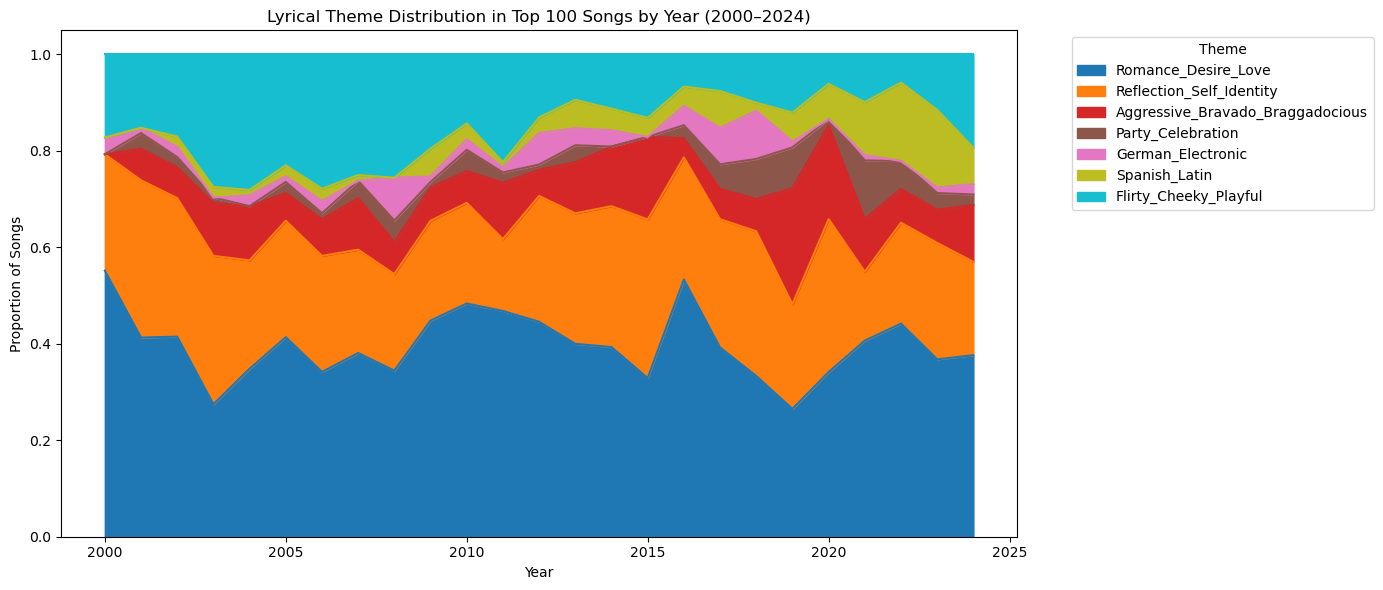

In [7]:
# Get topic distribution for each song
topic_distribution = lda.transform(dtm)

# Assign dominant topic to each song
df['dominant_topic'] = np.argmax(topic_distribution, axis=1)

# Count number of songs per topic per year
topic_counts_per_year = df.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize by total songs per year for proportional view
topic_distribution_per_year = topic_counts_per_year.div(topic_counts_per_year.sum(axis=1), axis=0)

# Plotting the topic distribution over the years
plt.figure(figsize=(14, 6))
topic_distribution_per_year.rename(columns=topic_labels).plot(
    kind='area', stacked=True, cmap='tab10', figsize=(14, 6)
)

plt.title('Lyrical Theme Distribution in Top 100 Songs by Year (2000–2024)')
plt.ylabel('Proportion of Songs')
plt.xlabel('Year')
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

To answer the second sub-question, I used a natural language processing technique called LDA to perform topic modelling on the lyrics.

The thematic landscape shows clear evolutionary patterns:
- Romance/Desire/Love (blue) consistently dominates, typically comprising 30-50% of popular songs, though it shows some decline in recent years.
- Reflection/Self-Identity themes (orange) have dramatically expanded, especially from 2010 onward, suggesting increased focus on personal identity and mental health.
- Aggressive/Bravado themes (red) maintain steady presence (15-25%), with notable peaks in the mid to late 2010s (hypebeast era).

Emerging Themes:
- Spanish/Latin influences become more prominent in the 2010s-2020s
- Electronic/German influences appear sporadically
- Flirty/Cheeky/Playful themes (light blue) remain consistent but relatively small

Celebration themes show interesting fluctuations, with peaks in certain years suggesting cyclical cultural moods.

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

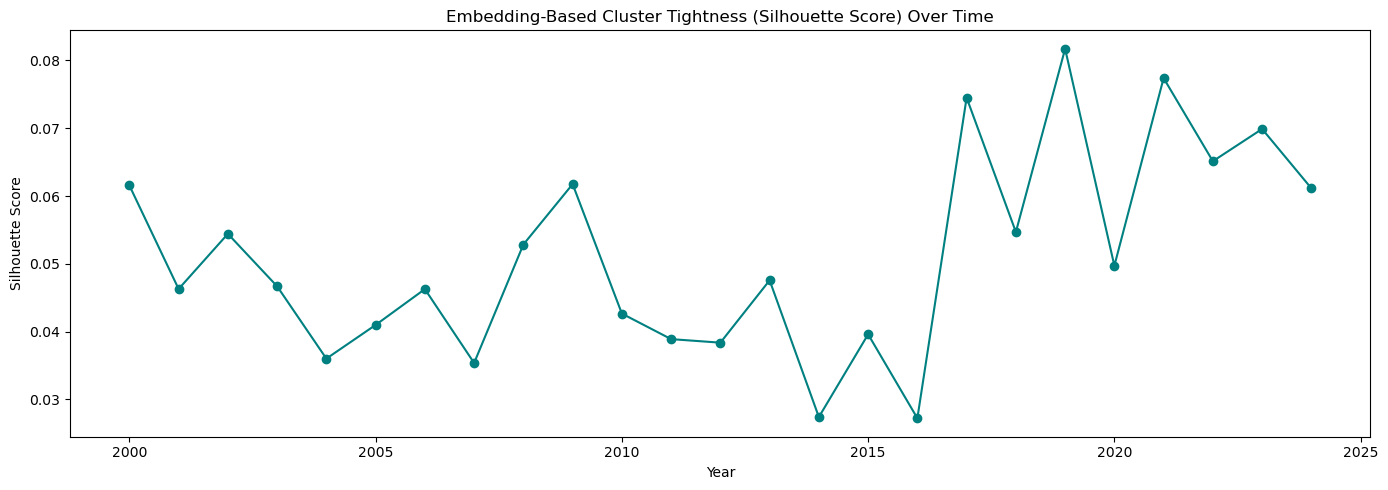

In [8]:
# Compute embeddings for each song's lyrics
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['clean_lyrics'].tolist(), show_progress_bar=True)

# Cluster lyrics for each year and track cluster tightness (silhouette score)
years = sorted(df['year'].unique())
cluster_scores = []

# Calculate silhouette score for each year's embeddings
for year in years:
    idx = df['year'] == year
    year_embeds = embeddings[idx]
    if len(year_embeds) < 5:
        cluster_scores.append(np.nan)
        continue
    # Choose a reasonable number of clusters
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(year_embeds)
    score = silhouette_score(year_embeds, labels)
    cluster_scores.append(score)

# Plotting the cluster tightness over the years
plt.figure(figsize=(14,5))
plt.plot(years, cluster_scores, marker='o', color='teal')
plt.title('Embedding-Based Cluster Tightness (Silhouette Score) Over Time')
plt.xlabel('Year')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

To answer the third sub-question, I used the silhouette score to measure the clustering of the top hits from each year.

The overall trajectory from 2000-2024 shows a lack in change of silhouette scores (from ~0.06 to ~0.06), suggesting song similarity has been more or less at the same level.

Volatile Clustering: However, the high volatility in clustering scores indicates that homogeneity isn't linear:
- 2018-2019: Peak clustering (0.075-0.08) suggests maximum musical similarity
- 2020: Sharp drop indicates diversification during pandemic
- Recent years: Continued volatility suggests ongoing experimentation

Periodic Diversification: Certain periods (2004, 2006, 2014, 2017, 2020) show increased musical diversity, perhaps maybe correlated with major cultural or technological shifts.

### Main Research Question: 

The data reveals several key insights about shifting cultural moods and industry trends:

#### Cultural Mood Shifts:
1. Optimism to Complexity: The clear decline from early 2000s optimism to more emotionally complex recent music reflects broader cultural shifts toward acknowledging mental health, social issues, and uncertainty.
2. Introspection Revolution: The dramatic rise in self-reflective themes suggests a culture increasingly focused on identity, authenticity, and personal growth.
3. Emotional Volatility: The extreme swings in both sentiment and clustering suggest a culture experiencing rapid change and uncertainty.

#### Industry Trends:
1. Algorithmic Influence: The clustering volatility may reflect how streaming algorithms and playlist culture create both homogenization pressures and niche diversification.
2. Global Integration: The emergence of Spanish/Latin themes reflects industry globalization and the rise of Latin music in mainstream charts.


#### Cultural Implications:
The data suggests we've moved from an era of relatively straightforward emotional expression (early 2000s) to one of complex cultural moods. Popular music now serves as both escape (romance, party themes) and processing mechanism (reflection, identity themes) for a society dealing with change and uncertainty.

The industry appears to be caught between market pressures toward homogenization and cultural demands for authentic, diverse expression - resulting in the volatile patterns we see across all three metrics.